<a href="https://colab.research.google.com/github/JayawardanaJTH/Train-robot-to-climb-staircase/blob/test/staircase_classification_vgg16.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Identify staircases using VGG16 model**

---





# Mount google drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Import libraries

In [3]:
import keras, os
import cv2
from tensorflow.keras.models import Sequential, Model,load_model
from tensorflow.keras.layers import Dense, Flatten, Lambda, Input, MaxPool2D, Conv2D, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import VGG16
from sklearn.model_selection import train_test_split
from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt
import numpy as np
from glob import glob
import os
import shutil
import random
import math

# Get the data set path from the Google drve



In [ ]:
IMAGE_SIZE = [224,224]

# positive_data_set = '/content/drive/MyDrive/Dataset/Filtered_data_set/Positive_data/Positive/'
# negative_data_set = '/content/drive/MyDrive/Dataset/Filtered_data_set/Negative_data/Negative/'

positive_data_set = '/content/drive/MyDrive/Dataset/Sec_Filtered_data_set/Positive/p/'
negative_data_set = '/content/drive/MyDrive/Dataset/Sec_Filtered_data_set/Negative/n/'



In [ ]:
all_positive = os.listdir(positive_data_set)
all_negative = os.listdir(negative_data_set)

print("No of positive images {}".format(len(all_positive)))
print("No of negative images {}".format(len(all_negative)))

No of positive images 2497
No of negative images 1025


# Save images which selected by randomly to google drive

In [ ]:
train_positive_path = './drive/MyDrive/Dataset/Divide_set/train/positive'
train_negative_path = './drive/MyDrive/Dataset/Divide_set/train/negative'
test_positive_path = './drive/MyDrive/Dataset/Divide_set/test/positive'
test_negative_path = './drive/MyDrive/Dataset/Divide_set/test/negative'

train_path = './drive/MyDrive/Dataset/Divide_set/train'
test_path = './drive/MyDrive/Dataset/Divide_set/test'

In [ ]:
if(os.path.isdir(train_positive_path)):
  shutil.rmtree(train_positive_path)
  os.makedirs(train_positive_path)

if(os.path.isdir(train_negative_path)):
  shutil.rmtree(train_negative_path)
  os.makedirs(train_negative_path)

if(os.path.isdir(test_positive_path)):
  shutil.rmtree(test_positive_path)
  os.makedirs(test_positive_path)

if(os.path.isdir(test_negative_path)):
  shutil.rmtree(test_negative_path)
  os.makedirs(test_negative_path)


In [ ]:
for image in random.sample(all_positive,2000):
  shutil.copy(positive_data_set + image, train_positive_path)

for image in random.sample(all_negative,1000):
  shutil.copy(negative_data_set + image, train_negative_path)

for image in random.sample(all_positive,500):
  shutil.copy(positive_data_set + image, test_positive_path)

for image in random.sample(all_negative,500):
  shutil.copy(negative_data_set + image, test_negative_path)

Increase the data set volume by **transformation**

In [ ]:
train_set = ImageDataGenerator(rescale=1./255,rotation_range=2, horizontal_flip=True, vertical_flip=True,zoom_range= 0.2, shear_range=0.2)
test_set = ImageDataGenerator(rescale=1./255,rotation_range=2, horizontal_flip=True, vertical_flip=True,zoom_range= 0.2, shear_range=0.2)

In [ ]:
train_data = train_set.flow_from_directory(train_path,target_size=(224,224), batch_size=32, class_mode = 'categorical')
test_data = test_set.flow_from_directory(test_path,target_size=(224,224), batch_size=32, class_mode = 'categorical')

Found 3000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [ ]:
train_data.class_indices
test_data.class_indices

{'negative': 0, 'positive': 1}

In [ ]:
class_mask = ['Staircase not detected', 'Staircase Detected']

Here use pre trained vgg16 model

That model load to the variable

In [ ]:
vgg16 = VGG16(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)

58900480/58889256 [==============================] - 0s 0us/step


In [ ]:
for layer in vgg16.layers:
  layer.trainable = False

In [ ]:
folders = glob(test_path+"/*")

In [ ]:
len(folders)

2

Here add rest part of the vgg16 model

In [ ]:
dropout = Dropout(0.25)(vgg16.output)
x = Flatten()(dropout)

In [ ]:
prediction = Dense(len(folders),activation='softmax')(x)

model = Model(inputs=vgg16.input, outputs=prediction)

In [ ]:
model.compile(optimizer='adam', loss=keras.losses.categorical_crossentropy, metrics=['accuracy'])

Here can see a structure of the model

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

Here create two callbacks for improve the accuracy of the model

In [ ]:
from keras.callbacks import ModelCheckpoint, EarlyStopping

checkpoint = ModelCheckpoint("vgg16_1.h5", monitor='val_accuracy', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)
early = EarlyStopping(monitor='val_accuracy', min_delta=0, patience=20, verbose=1, mode='auto')

# Train the model

In [ ]:
hist = model.fit_generator(steps_per_epoch=30,generator=train_data, validation_data= test_data, validation_steps=10,epochs=100,callbacks=[checkpoint,early])
model.save('vggclf.h5')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  """Entry point for launching an IPython kernel.


Epoch 1/100
30/30 [==============================] - ETA: 0s - loss: 0.5223 - accuracy: 0.7990
Epoch 00001: val_accuracy improved from -inf to 0.82500, saving model to vgg16_1.h5
30/30 [==============================] - 70s 2s/step - loss: 0.5223 - accuracy: 0.7990 - val_loss: 0.4502 - val_accuracy: 0.8250
Epoch 2/100
30/30 [==============================] - ETA: 0s - loss: 0.2555 - accuracy: 0.9181
Epoch 00002: val_accuracy improved from 0.82500 to 0.94375, saving model to vgg16_1.h5
30/30 [==============================] - 56s 2s/step - loss: 0.2555 - accuracy: 0.9181 - val_loss: 0.1878 - val_accuracy: 0.9438
Epoch 3/100
30/30 [==============================] - ETA: 0s - loss: 0.2022 - accuracy: 0.9146
Epoch 00003: val_accuracy improved from 0.94375 to 0.95312, saving model to vgg16_1.h5
30/30 [==============================] - 46s 2s/step - loss: 0.2022 - accuracy: 0.9146 - val_loss: 0.1479 - val_accuracy: 0.9531
Epoch 4/100
30/30 [==============================] - ETA: 0s - loss: 0

In [ ]:
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)

Lets see how the data set have learned and trained

In [ ]:
result = model.evaluate(test_data,batch_size=32)
print("test_loss, test accuracy",result)

32/32 [==============================] - 36s 1s/step - loss: 0.0292 - accuracy: 0.9900
test_loss, test accuracy [0.029162302613258362, 0.9900000095367432]


# Find out model accuracy and loss

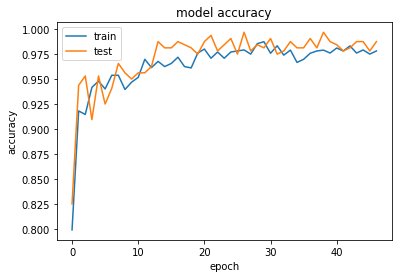

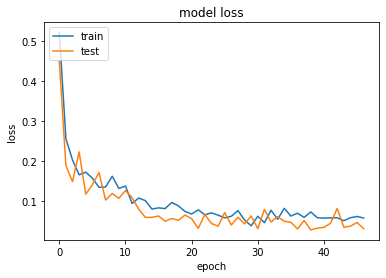

In [ ]:
# summarize history for accuracy
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# Testing time

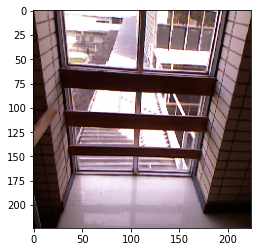

In [ ]:
img = load_img("/content/drive/MyDrive/Dataset/Sec_Filtered_data_set/Negative/n/46-e.png", target_size=(224,224))
# img = image.load_img("/content/drive/MyDrive/Dataset/Filtered_data_set/Negative_data/Negative/0.png", target_size=(224,224))
img = np.asarray(img)
plt.imshow(img)
img = np.expand_dims(img, axis=0)

In [ ]:
saved_model = load_model('/content/vggclf.h5')
output = saved_model.predict(img)


Here show the output of the predicted result

In [ ]:
print(output)

pred = class_mask[np.argmax(output)]
# pred = class_mask[np.argmax(model.predict(img))]
print(pred)

[[1. 0.]]
Staircase not detected


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  after removing the cwd from sys.path.


<Figure size 432x288 with 0 Axes>

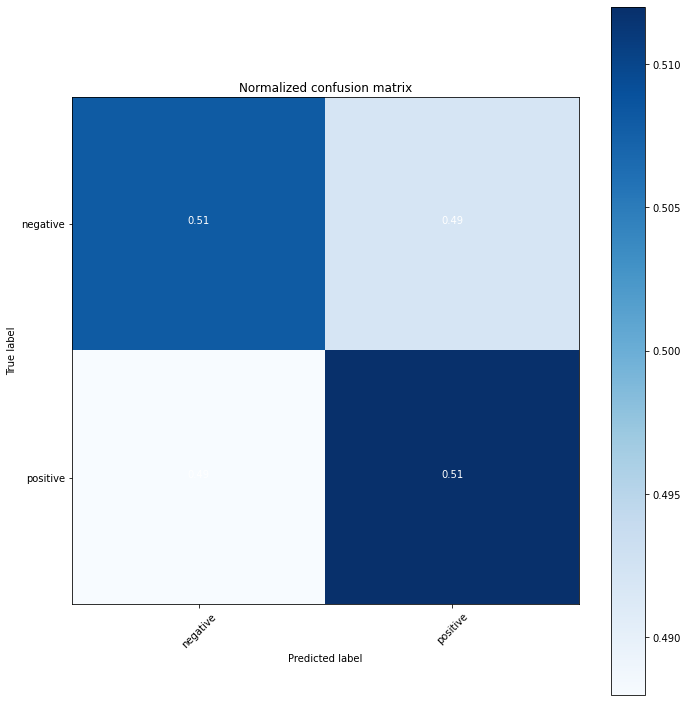

In [ ]:
# show the confusion matrix of our predictions

# compute predictions
predictions = saved_model.predict_generator(generator=test_data)
y_pred = [np.argmax(probas) for probas in predictions]
y_test = test_data.classes
class_names = test_data.class_indices.keys()

from sklearn.metrics import confusion_matrix
import itertools

def plot_confusion_matrix(cm, classes, title='Confusion matrix', cmap=plt.cm.Blues):
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plt.figure(figsize=(10,10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    
# compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)
np.set_printoptions(precision=2)

# plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, title='Normalized confusion matrix')
plt.show()

# Get boundary rectangle for a staircase

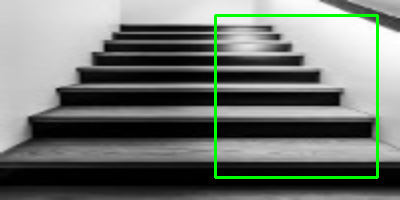

In [4]:
stair_cascade=cv2.CascadeClassifier(r"/content/drive/MyDrive/Classification/3/cascade3.xml")

img= cv2.imread(r"6.jpeg")

resized = cv2.resize(img,(400,200))

gray=cv2.cvtColor(resized,cv2.COLOR_BGR2GRAY)
stairs=stair_cascade.detectMultiScale(gray,6.5,17)

for(x,y,w,h) in stairs:
    resized=cv2.rectangle(resized,(x,y),(x+w,y+h),(0,255,0),2)
cv2_imshow(resized)

# Get count of steps

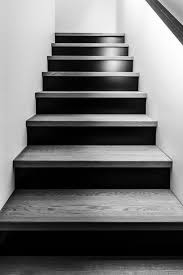

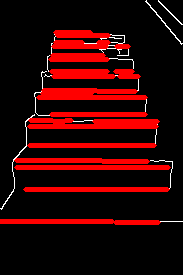

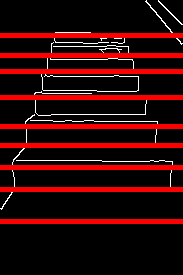

Stair count :8


In [ ]:
def getStepCount():

  image = cv2.imread("1.jpg")
  gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

  gaussian_image = cv2.GaussianBlur(gray_image,(5,5),0,0)
 
  canny_image = cv2.Canny(gaussian_image,80,240,3)

  output_image = cv2.cvtColor(canny_image, cv2.COLOR_GRAY2BGR)
  output_image2 = cv2.cvtColor(canny_image, cv2.COLOR_GRAY2BGR)
  output_image3 = cv2.cvtColor(canny_image, cv2.COLOR_GRAY2BGR)

  lines = list()
  
  lines = cv2.HoughLinesP(canny_image,1,math.pi/180,30,40,5)

  for i in range(0,len(lines)):
    line = lines[i][0]
    cv2.line(output_image,(line[0],line[1]),(line[2],line[3]),(0,0,255),3,5)
  

  y_values = list()
  x_values = list()

  # remove vertical lines
  for i in range(0, len(lines)):
    line = lines[i][0]

    if (abs(line[1] - line[3])) < 5:
      y_values.append([line[1],line[3]])
      x_values.append([line[0],line[2]])

    if (abs(line[0] - line[2])) > 100:
      y_values.append([line[1],line[3]])
      x_values.append([line[0],line[2]])

  for i in range(0, len(y_values)):
    y_ax = y_values[i]
    x_ax = x_values[i]
    cv2.line(output_image2,(x_ax[0],y_ax[0]),(x_ax[1],y_ax[1]),(0,0,255),3,5)

  # remove unwanted horizontal lines
  y_ax = list()
  y_ax.append(y_values[0][0])
  stair_count = 0;
  flag = 1

  for i in range(0, len(y_values)):
    
    line = y_values[i]

    for j in range(1, len(y_ax)):

      step_heigth_mean = 15

      if (abs(y_ax[j] - line[1]) < step_heigth_mean):
        flag = 0
    
    if flag:
      cv2.line(output_image3,(0,line[1]),(output_image3.shape[1],line[1]),(0,0,255),3,5)
      stair_count = stair_count + 1
      y_ax.append(line[1])

    flag = 1

  cv2_imshow(gray_image)
  cv2_imshow(output_image2)
  cv2_imshow(output_image3)
  # cv2_imshow(canny_image)

  print("Stair count :"+ str(stair_count-1))

getStepCount()

# Save data to drive

In [ ]:
# os.makedirs('./drive/MyDrive/Dataset/Divide_set/weights_4_final')
# shutil.copy('/content/vgg16_1.h5', './drive/MyDrive/Dataset/Divide_set/weights_4_final')
# shutil.copy('/content/vggclf.h5', './drive/MyDrive/Dataset/Divide_set/weights_4_final')

# model.save('weig.xml')
# symlinks=False
# ignore=None
# for item in os.listdir('/content/weig.xml'):
#         s = os.path.join('/content/weig.xml', item)
#         d = os.path.join('./drive/MyDrive/Dataset/Divide_set/weights', item)
#         if os.path.isdir(s):
#             shutil.copytree(s, d, symlinks, ignore)
#         else:
#             shutil.copy2(s, d)

'./drive/MyDrive/Dataset/Divide_set/weights_4_final/vggclf.h5'